In [1]:
import json
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
import pymorphy2
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from config import PATH_TO_SAVE_PROCESSED_FILES

from utils.text_data_transformation import remove_stop_words
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
path_to_subdialog_keywords = os.path.join(PATH_TO_SAVE_PROCESSED_FILES, "subdialog_keywords.csv")
path_to_save_result_csv = os.path.join(PATH_TO_SAVE_PROCESSED_FILES, "subdialogs_topics.csv")

In [2]:
# 0) Firstly, run tf_idf_for_subdialogs.ipynb to get subdialog_keywords.csv file
df = pd.read_csv(path_to_subdialog_keywords)

In [3]:
# DO NOT delete this part, because it is a method to use jsons for this code!!!!!!!!!

# # Import Dataset
# path_to_articles = '../static/ukr_articles'
# data = pd.read_csv(path_to_articles, sep = ';', header = None)
#
# LANGUAGE = "ua"
# stop_words = remove_stop_words(data, LANGUAGE, "get_stop_words")
#
# # write your number of rows to analyse. max == 695,
# # but to clean and analyse 30 rows is spending 6 minutes
# df = pd.DataFrame(data[:20])
#
# df.columns = ["id", "title", "en_title", "content", "date", "source_url",
#                   "article_url"]
# # df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
# # print(df.target_names.unique())
# df.head()


In [4]:
# Convert to list
data = df.doc.values.tolist()

pprint(data[:1])


[' \u200b50 русскоязычных YouTube-каналов о языках программирования \n'
 '\n'
 'Подборка YouTube-каналов и плейлистов, посвящённых различным языкам '
 'программирования: Python, JavaScript, C/C++, Java, Kotlin, Go, PHP и C#. '
 'Каждый найдёт что-то своё.\n'
 '\n'
 'https://proglib.io/sh/BmlwSzRKUn В мире компьютерных игр не только безумное '
 'разнообразие жанров 🎲🎮🕹👾, но и огромные бюджеты международных IT-гигантов. '
 'Стать разработчиком игр = обеспечить себя захватывающей работой и высокой '
 'зарплатой. Какие шаги предпринять, ещё учась в школе, расскажут 12 сентября '
 '(сб) в 12:00 на IT-субботнике GeekBrains «Из геймера в разработчики игр».\n'
 ' \n'
 ' Кому будет полезно:\n'
 ' 👪 Родители, чьи дети любят компьютерные игры. Вы узнаете, как направить '
 'интерес в полезное русло и позаботиться о будущем ребёнка.\n'
 ' 🎮 Школьники, которые задумываются о выборе профессии. Вы поймете, чем '
 'привлекательна разработка игр и подходит ли она вам.\n'
 ' \n'
 ' Бесплатная регистрация

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['русскоязычных', 'youtube', 'каналов', 'языках', 'подборка', 'youtube', 'каналов', 'плеилистов', 'посвященных', 'различным', 'языкам', 'python', 'javascript', 'java', 'kotlin', 'go', 'php', 'каждыи', 'наидет', 'что', 'то', 'свое', 'https', 'proglib', 'io', 'sh', 'bmlwszrkun', 'мире', 'компьютерных', 'игр', 'не', 'только', 'безумное', 'разнообразие', 'жанров', 'но', 'огромные', 'бюджеты', 'международных', 'it', 'гигантов', 'стать', 'разработчиком', 'игр', 'обеспечить', 'себя', 'захватывающеи', 'работои', 'высокои', 'зарплатои', 'какие', 'шаги', 'предпринять', 'еще', 'учась', 'школе', 'расскажут', 'сентября', 'сб', 'на', 'it', 'субботнике', 'geekbrains', 'из', 'геимера', 'разработчики', 'игр', 'кому', 'будет', 'полезно', 'родители', 'чьи', 'дети', 'любят', 'компьютерные', 'игры', 'вы', 'узнаете', 'как', 'направить', 'интерес', 'полезное', 'русло', 'позаботиться', 'будущем', 'ребенка', 'школьники', 'которые', 'задумываются', 'выборе', 'профессии', 'вы', 'поимете', 'чем', 'привлекательна

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['русскоязычных', 'youtube', 'каналов', 'языках', 'подборка', 'youtube', 'каналов', 'плеилистов', 'посвященных', 'различным', 'языкам', 'python', 'javascript', 'java', 'kotlin', 'go', 'php', 'каждыи', 'наидет', 'что', 'то', 'свое', 'https', 'proglib_io', 'sh', 'bmlwszrkun', 'мире', 'компьютерных', 'игр', 'не', 'только', 'безумное', 'разнообразие', 'жанров', 'но', 'огромные', 'бюджеты', 'международных', 'it', 'гигантов', 'стать', 'разработчиком', 'игр', 'обеспечить', 'себя', 'захватывающеи', 'работои', 'высокои', 'зарплатои', 'какие', 'шаги', 'предпринять', 'еще', 'учась', 'школе', 'расскажут', 'сентября', 'сб', 'на', 'it', 'субботнике', 'geekbrains', 'из', 'геимера', 'разработчики', 'игр', 'кому', 'будет', 'полезно', 'родители', 'чьи', 'дети', 'любят', 'компьютерные', 'игры', 'вы_узнаете', 'как', 'направить', 'интерес', 'полезное', 'русло', 'позаботиться', 'будущем', 'ребенка', 'школьники', 'которые', 'задумываются', 'выборе', 'профессии', 'вы', 'поимете', 'чем', 'привлекательна', 'раз

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(data, lang, cube):
#     """
#
#     :param lang: "ru", "ua" or "en"
#     :param cube: only for "ua"an object after these commands cube = Cube(verbose=True); cube.load("uk")
#     :return: cleaned text from synonyms
#     """
#     lemmas = []
#     for i in range(len(data)):
#         data[i] = " ".join(data[i])
#
#     data = ". ".join(data)
#
#     if lang == "ru":
#         lemmas = " ".join(pymorphy2.MorphAnalyzer().parse(np.unicode(word))[0].normal_form for word in msg.split())
#
#     elif lang in ("ua", "en"):
#         sentences = cube(data)
#
#         for sentence in sentences:  # note we selected the first sentence (sentence[0])
#             sentence_lemma = []
#             for entry in sentence:
#                 sentence_lemma.append(entry.lemma)
#
#             lemmas.append(sentence_lemma)
#
#     return lemmas

In [8]:
from cube.api import Cube


# Form Bigrams
data_words_bigrams = make_bigrams(data_words)
print(data_words_bigrams)

# If you have unlemmatized text data, so uncomment it !!!!!

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# # python3 -m spacy download en
# # nlp = spacy.load('en', disable=['parser', 'ner'])
# nlp = spacy.load('en_core_web_sm')
# # cube = Cube(verbose=True)
# # cube.load("en")
#

# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams)
# data_lemmatized = lemmatization(data_words_bigrams[:20], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


# cube = ""
# if LANGUAGE == "ua":
#     cube = Cube(verbose=True)
#     cube.load("uk")
#
# elif LANGUAGE == "en":
#     cube = Cube(verbose=True)
#     cube.load("en")

# data_lemmatized = lemmatization(data_words_bigrams, LANGUAGE, cube)
data_lemmatized = data_words_bigrams


[['русскоязычных', 'youtube', 'каналов', 'языках', 'подборка', 'youtube', 'каналов', 'плеилистов', 'посвященных', 'различным', 'языкам', 'python', 'javascript', 'java', 'kotlin', 'go', 'php', 'каждыи', 'наидет', 'что', 'то', 'свое', 'https', 'proglib_io', 'sh', 'bmlwszrkun', 'мире', 'компьютерных', 'игр', 'не', 'только', 'безумное', 'разнообразие', 'жанров', 'но', 'огромные', 'бюджеты', 'международных', 'it', 'гигантов', 'стать', 'разработчиком', 'игр', 'обеспечить', 'себя', 'захватывающеи', 'работои', 'высокои', 'зарплатои', 'какие', 'шаги', 'предпринять', 'еще', 'учась', 'школе', 'расскажут', 'сентября', 'сб', 'на', 'it', 'субботнике', 'geekbrains', 'из', 'геимера', 'разработчики', 'игр', 'кому', 'будет', 'полезно', 'родители', 'чьи', 'дети', 'любят', 'компьютерные', 'игры', 'вы_узнаете', 'как', 'направить', 'интерес', 'полезное', 'русло', 'позаботиться', 'будущем', 'ребенка', 'школьники', 'которые', 'задумываются', 'выборе', 'профессии', 'вы', 'поимете', 'чем', 'привлекательна', 'ра

In [9]:
print(data_lemmatized[:1])
 # Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[['русскоязычных', 'youtube', 'каналов', 'языках', 'подборка', 'youtube', 'каналов', 'плеилистов', 'посвященных', 'различным', 'языкам', 'python', 'javascript', 'java', 'kotlin', 'go', 'php', 'каждыи', 'наидет', 'что', 'то', 'свое', 'https', 'proglib_io', 'sh', 'bmlwszrkun', 'мире', 'компьютерных', 'игр', 'не', 'только', 'безумное', 'разнообразие', 'жанров', 'но', 'огромные', 'бюджеты', 'международных', 'it', 'гигантов', 'стать', 'разработчиком', 'игр', 'обеспечить', 'себя', 'захватывающеи', 'работои', 'высокои', 'зарплатои', 'какие', 'шаги', 'предпринять', 'еще', 'учась', 'школе', 'расскажут', 'сентября', 'сб', 'на', 'it', 'субботнике', 'geekbrains', 'из', 'геимера', 'разработчики', 'игр', 'кому', 'будет', 'полезно', 'родители', 'чьи', 'дети', 'любят', 'компьютерные', 'игры', 'вы_узнаете', 'как', 'направить', 'интерес', 'полезное', 'русло', 'позаботиться', 'будущем', 'ребенка', 'школьники', 'которые', 'задумываются', 'выборе', 'профессии', 'вы', 'поимете', 'чем', 'привлекательна', 'ра

In [10]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('bmlwszrkun', 1),
  ('geekbrains', 1),
  ('go', 1),
  ('https', 2),
  ('it', 2),
  ('java', 1),
  ('javascript', 1),
  ('kotlin', 1),
  ('php', 1),
  ('proglib_io', 2),
  ('python', 1),
  ('sh', 1),
  ('youtube', 2),
  ('безумное', 1),
  ('бесплатная', 1),
  ('будет', 1),
  ('будущем', 1),
  ('бюджеты', 1),
  ('вам', 1),
  ('все', 1),
  ('вы', 1),
  ('вы_узнаете', 1),
  ('выборе', 1),
  ('высокои', 1),
  ('геимера', 1),
  ('гигантов', 1),
  ('дети', 1),
  ('еще', 1),
  ('жанров', 1),
  ('задумываются', 1),
  ('зарплатои', 1),
  ('захватывающеи', 1),
  ('здесь', 1),
  ('игр', 4),
  ('игры', 1),
  ('из', 1),
  ('интерес', 1),
  ('каждыи', 1),
  ('как', 1),
  ('какие', 1),
  ('каналов', 2),
  ('компьютерные', 1),
  ('компьютерных', 1),
  ('кому', 1),
  ('которые', 1),
  ('ли', 1),
  ('любят', 1),
  ('международных', 1),
  ('мире', 1),
  ('на', 1),
  ('наидет', 1),
  ('направить', 1),
  ('не', 1),
  ('но', 1),
  ('обеспечить', 1),
  ('огромные', 1),
  ('она', 1),
  ('плеилистов', 1),
  

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"минута" + 0.018*"аудитория" + 0.008*"увидеть" + 0.007*"подобныи" + '
  '0.007*"привет" + 0.007*"купить" + 0.007*"гугл" + 0.006*"коучинга" + '
  '0.005*"верить" + 0.004*"документ"'),
 (1,
  '0.021*"код" + 0.018*"интернет" + 0.016*"мир" + 0.013*"and" + 0.012*"сфера" '
  '+ 0.012*"развивать" + 0.011*"современныи" + 0.011*"java" + 0.010*"изучение" '
  '+ 0.010*"если"'),
 (2,
  '0.079*"на" + 0.066*"не" + 0.033*"https" + 0.031*"все" + 0.030*"для" + '
  '0.027*"что" + 0.026*"как" + 0.016*"но" + 0.012*"ну" + 0.011*"это"'),
 (3,
  '0.046*"модуль" + 0.024*"там" + 0.024*"telegram" + 0.022*"за" + 0.021*"есть" '
  '+ 0.016*"концепция" + 0.015*"тебе" + 0.009*"теория" + 0.006*"или" + '
  '0.005*"очень"'),
 (4,
  '0.046*"com" + 0.037*"наш" + 0.032*"проект" + 0.029*"онлаин" + '
  '0.023*"команда" + 0.019*"facebook" + 0.018*"тип" + 0.016*"продукт" + '
  '0.016*"создать" + 0.014*"друг"'),
 (5,
  '0.038*"один" + 0.024*"какои" + 0.017*"дать" + 0.016*"сделать" + '
  '0.015*"канал" + 0.014*"по

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -21.258332711232526

Coherence Score:  0.4767760162531161


## Visualize the topics-keywords

In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

d:\python\envs\venv_telegram_analysis\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.346672 -0.057615       1        1  21.609507
5     -0.054183  0.277585       2        1  14.716005
14     0.014771 -0.081684       3        1  13.104245
4      0.029438 -0.037620       4        1  11.232615
17     0.005948 -0.005681       5        1  10.562140
1      0.032621 -0.010793       6        1   5.202030
6      0.033287 -0.022323       7        1   3.513566
7      0.026140 -0.006528       8        1   3.091508
2      0.031231 -0.010442       9        1   2.866235
10     0.025433 -0.006200      10        1   2.445150
19     0.024761 -0.005819      11        1   2.329264
13     0.023238 -0.005102      12        1   1.691677
15     0.024451 -0.005677      13        1   1.664557
8      0.019674 -0.003576      14        1   1.381167
3      0.024067 -0.005498      15        1   1.316690
9      0.020130 -0.003765      16        1   1.072467
0      0.018939 -0.003284      17        1   0.990862
11     0.016561 -0.002363      18        1   0.655618
16     0.015208 -0.001855      19        1   0.316469
12     0.014957 -0.001762      20        1   0.238225, topic_info=      Category         Freq      Term        Total  loglift  logprob
10     Default  1772.000000    python  1772.000000  30.0000  30.0000
425    Default  2098.000000      курс  2098.000000  29.0000  29.0000
1148   Default   735.000000    бизнес   735.000000  28.0000  28.0000
656    Default   711.000000       com   711.000000  27.0000  27.0000
566    Default   761.000000      один   761.000000  26.0000  26.0000
...        ...          ...       ...          ...      ...      ...
24588  Topic20     0.012051      коли     2.374363   0.7564 -10.2012
6060   Topic20     0.012051     фраза     2.374305   0.7564 -10.2012
5849   Topic20     0.012051      мозг     2.374653   0.7563 -10.2012
3179   Topic20     0.012051      дуже     2.374569   0.7563 -10.2012
24438  Topic20     0.012051  запушити     2.374576   0.7563 -10.2012

[791 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
474      10  0.315536       action
520       7  0.803962        adobe
98        6  0.973693          and
308       8  0.915694      android
813      18  0.478546      angular
...     ...       ...          ...
184       9  0.942874          это
1475      4  0.981662       эффект
915      10  0.965457  эффективныи
392       2  0.987279         язык
1894     12  0.848718         ясно

[509 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 6, 15, 5, 18, 2, 7, 8, 3, 11, 20, 14, 16, 9, 4, 10, 1, 12, 17, 13])

In [15]:
# TODO: in README.md
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ.update({'MALLET_HOME':r'D:/libs/mallet-2.0.8/'})
mallet_path = 'D:/libs/mallet-2.0.8/bin/mallet' # update this path(you should write here full path to file,
# not relative)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [16]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('компания', 0.028340748063931456),
   ('бизнес', 0.015818091942659415),
   ('новость', 0.010380622837370242),
   ('акция', 0.008568133135607184),
   ('новыи', 0.007744274180260339),
   ('россия', 0.007744274180260339),
   ('развитие', 0.007414730598121601),
   ('получить', 0.007085187015982864),
   ('группа', 0.006920415224913495),
   ('день', 0.006920415224913495)]),
 (7,
  [('онлаин', 0.024838549428713365),
   ('работа', 0.023182646133465806),
   ('проект', 0.02102997184964398),
   ('proglib_io', 0.01639344262295082),
   ('навык', 0.015896671634376552),
   ('специалист', 0.015565490975327041),
   ('обучение', 0.014737539327703263),
   ('практика', 0.013743997350554728),
   ('опыт', 0.013412816691505217),
   ('знание', 0.012916045702930949)]),
 (13,
  [('жизнь', 0.023303834808259587),
   ('человек', 0.021976401179941003),
   ('свои', 0.01991150442477876),
   ('ваш', 0.013569321533923304),
   ('мышление', 0.013421828908554572),
   ('цель', 0.012831858407079646),
   ('мозг', 0.

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

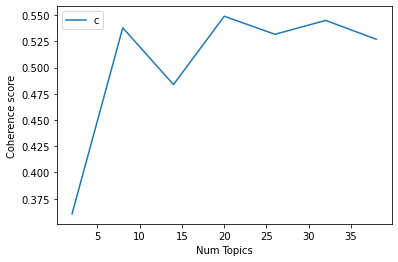

In [18]:
import matplotlib.pyplot as plt
#Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3605
Num Topics = 8  has Coherence Value of 0.5379
Num Topics = 14  has Coherence Value of 0.4837
Num Topics = 20  has Coherence Value of 0.5489
Num Topics = 26  has Coherence Value of 0.5317
Num Topics = 32  has Coherence Value of 0.5449
Num Topics = 38  has Coherence Value of 0.5269


In [20]:

# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.029*"бизнес" + 0.017*"продажа" + 0.017*"узнать" + 0.015*"реклама" + '
  '0.015*"клиент" + 0.014*"instagram" + 0.013*"зарабатывать" + 0.013*"свои" + '
  '0.013*"контент" + 0.012*"продвижение"'),
 (1,
  '0.022*"узнать" + 0.020*"видео" + 0.016*"дизаин" + 0.016*"научиться" + '
  '0.016*"создание" + 0.013*"создавать" + 0.012*"работа" + 0.012*"анимация" + '
  '0.009*"работать" + 0.009*"разныи"'),
 (2,
  '0.074*"облако_mail" + 0.052*"курс" + 0.051*"описание_teletype" + '
  '0.034*"саит" + 0.022*"переити_изучение" + 0.020*"описание_telegraph" + '
  '0.020*"часть" + 0.017*"яндекс_диск" + 0.015*"программа" + '
  '0.014*"научиться"'),
 (3,
  '0.074*"книга" + 0.051*"автор" + 0.022*"читать_кратко" + 0.020*"free_edu" + '
  '0.016*"слушать_кратко" + 0.015*"история" + 0.015*"канал_бесплатныи" + '
  '0.013*"версия" + 0.013*"cлушать_текстовыи" + 0.013*"идея"'),
 (4,
  '0.068*"курс" + 0.028*"описание" + 0.026*"получить" + 0.024*"изучить" + '
  '0.023*"работа" + 0.019*"один" + 0.018*"знание" + 0

In [21]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [22]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4632,"бизнес, продажа, узнать, реклама, клиент, inst...",курс трафик smm интернетмаркетинг арбитраж ч...
1,1.0,0.4533,"узнать, видео, дизаин, научиться, создание, со...",создание обработка фотография часть курс поз...
2,2.0,0.5156,"облако_mail, курс, описание_teletype, саит, пе...",вебдизайн вёрстка html css сайтостроение час...
3,3.0,0.4175,"книга, автор, читать_кратко, free_edu, слушать...",сто старший автор соня аррисон долголетие по...
4,4.0,0.4317,"курс, описание, получить, изучить, работа, оди...",онлайн школа interra открытый набор курс про...


In [23]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.to_csv(path_to_save_result_csv, index=False)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,14.0,"на, не, что, как, по, то, это, для, все, за",254.0,0.0602
1.0,14.0,"на, не, что, как, по, то, это, для, все, за",121.0,0.0287
2.0,14.0,"на, не, что, как, по, то, это, для, все, за",75.0,0.0178
3.0,9.0,"переходить_изучение, репостите_потерять, приві...",295.0,0.0699
4.0,16.0,"дать, язык, использовать, код, proglib_io, кни...",143.0,0.0339
...,...,...,...,...
4215.0,7.0,"dou_ua, дуже, шукати, працювати, робота, компа...",NaN,NaN
4216.0,14.0,"на, не, что, как, по, то, это, для, все, за",NaN,NaN
4217.0,12.0,"грн, промокод, якщо, якии, всі, доставка, замо...",NaN,NaN
4218.0,10.0,"курс, программа, дробныи_переити, наш_бот, пра...",NaN,NaN
